Let's play with a traffic classification example. We will use a pre-cooked (subset of a) dataset containing traffic captures from different mobile applications.

More information can be found on this paper:

Y. Heng et al: "UTMobileNetTraffic2021: A Labeled Public Network Traffic Dataset"

The file captures are contained in the 'traffic_captures' folder as CSV files. Each file is labeled with the application that was running on the mobile phone during the capture (ground truth label) and contains several header-only packet information. Let's open one of these file to have an idea of the content.



In [ ]:
from google.colab import drive
import pandas as pd


drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/3 - Traffic Classification/traffic_captures/dropbox_download_2019-03-16_11-46-54_5bd0c615.csv')

#much easier than looping over all packets!
df_tcp = df[df["ip.proto"]==6]
df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])

for flow, df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
  print(flow)
  display(df_flow)

In [ ]:
def extract_features(flow,df_flow):
  #compute flow features:
  flow_features = {}
  if(flow[0].split('.')[0]=='10'):
    flow_features['direction'] = 'uplink'
  else:
    flow_features['direction'] = 'downlink'

  flow_features['num_packets'] = len(df_flow);
  pkt_sizes = df_flow['ip.len'].astype(float)
  flow_features['total_bytes'] = pkt_sizes.sum()
  flow_features['min_pkt_size'] = pkt_sizes.min()
  flow_features['max_pkt_size'] = pkt_sizes.max()
  flow_features['mean_pkt_size'] = pkt_sizes.mean()
  flow_features['std_pkt_size'] = pkt_sizes.std()
  iat = pd.to_datetime(df_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:] #
  flow_features['min_iat'] = iat.min()
  flow_features['max_iat'] = iat.max()
  flow_features['mean_iat'] = iat.mean()
  flow_features['std_iat'] = iat.std()
  flow_features['dur'] = iat.sum()
  flow_features['dport'] = flow[3]
  flow_features['sport'] = flow[2]
  return flow_features

df_udp = df[df["ip.proto"]==17]
df_tcp = df[df["ip.proto"]==6]

df_flows_udp = df_udp.groupby(["ip.src","ip.dst","udp.srcport","udp.dstport"])
df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])

for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
  flow_features = extract_features(flow,df_flow)
  display(flow)
  display(flow_features)




Let's try to build a traffic classifier using only downlink TCP features. First, we will construct the dataset.

In [ ]:
from os import listdir
from os.path import isfile, join
import numpy as np

path = '/content/drive/MyDrive/Colab Notebooks/3 - Traffic Classification/traffic_captures/'
tcpdumpfiles = [f for f in listdir(path) if isfile(join(path, f))]
apps = np.unique([f.split('_')[0] for f in tcpdumpfiles])
print(apps, len(apps), len(tcpdumpfiles))

dataset = pd.DataFrame()
for f in tcpdumpfiles:
  print('Processing file  ', f)
  df = pd.read_csv(join(path,f))
  df_tcp = df[df["ip.proto"]==6]
  df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
  for flow,df_flow in df_flows_tcp: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
    flow_features = extract_features(flow,df_flow)
    flow_features['app'] = f.split('_')[0];
    if(flow_features['direction']=='downlink'):
      dataset = dataset.append(flow_features,ignore_index=True);

display(dataset)
dataset.to_csv('/content/drive/MyDrive/Colab Notebooks/3 - Traffic Classification/traffic_classification_dataset.csv', index=False, line_terminator='\n')

Now, we'll divide our dataset in two parts. One will be used to train a classification model (the training set). We'll use 80% of data for that. The remaining 20% of data will be used to evaluate the performance of the classifier..

0.7673469387755102


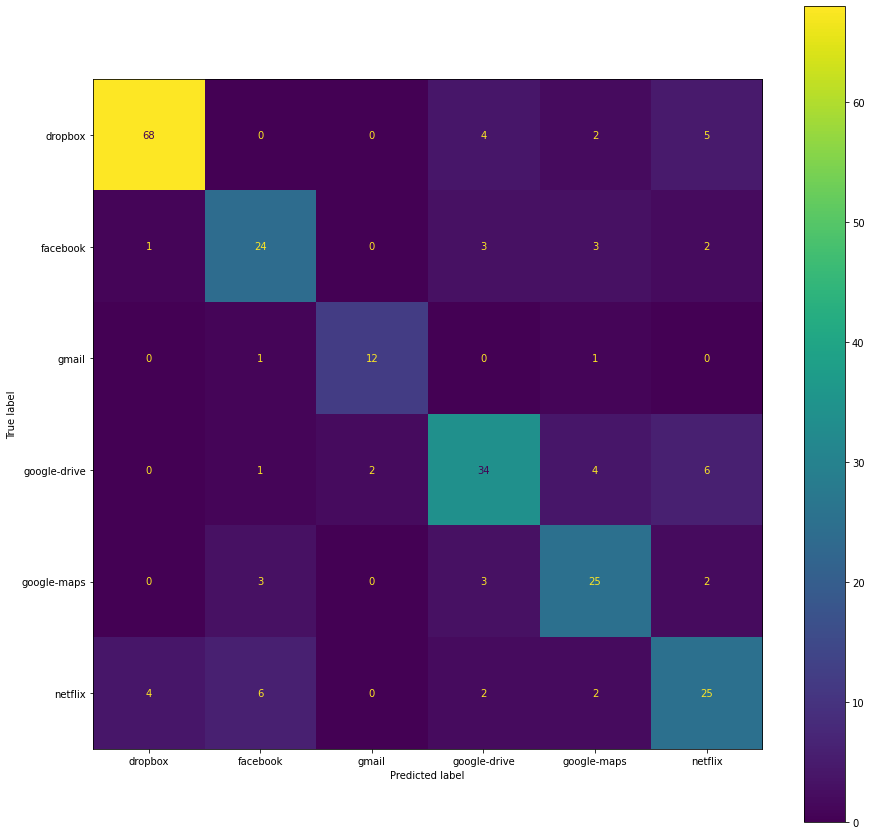

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


X = dataset.drop(['direction','sport','dport'],axis=1).dropna();
APP = X['app']
X = X.drop(['app'],axis=1)

idx = np.random.permutation(len(X))
num_train_obs = np.floor(0.7*len(X))

train_idx = idx[1:int(num_train_obs)]
test_idx = idx[int(num_train_obs):]

# normalization
X_norm = pd.DataFrame()
for key in X:
  temp = X[key]
  temp_norm = (temp-temp.mean())/temp.std();
  X_norm[key] = temp_norm

# split train / test
X_norm_train = X_norm.iloc[train_idx]
X_norm_test = X_norm.iloc[test_idx]

APP_train = APP.iloc[train_idx]
APP_test = APP.iloc[test_idx]

#K-NN classifier: for each entry in the test set, search the closest entry in the train set and assign value!
i = 0;
accuracy = 0
K = 10
APP_test_predicted = []
for index, row in X_norm_test.iterrows():
  #test_entry = row.values.tolist()
  distances = []
  for ii, rr in X_norm_train.iterrows():
    #train_entry = rr.values.tolist()
    #distances.append(np.linalg.norm(np.array(test_entry)-np.array(train_entry)))
    distances.append(np.linalg.norm(np.array(row.to_numpy() - rr.to_numpy())))

  min_idx = np.argmin(distances)

  #sorted_idx = np.argsort(distances)
  #predicted_app = APP_train.iloc[sorted_idx[1:K+1]].mode()

  predicted_app = APP_train.iloc[min_idx]
  APP_test_predicted.append(predicted_app)
  if(APP_test.iloc[i] == predicted_app):
      accuracy = accuracy+1
  i = i+1

print(accuracy/len(APP_test))
fig, ax = plt.subplots(figsize=(15, 15));
ConfusionMatrixDisplay.from_predictions(APP_test_predicted, APP_test, ax=ax);


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample


from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import  classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


#constructing features
le = LabelEncoder();
scaler = StandardScaler();


#using only traffic features
X = dataset.drop(['direction','sport','dport'],axis=1).dropna();

#port-based classification, usable port information is source port
#X = dataset[['sport','app']]


Y = le.fit_transform(X['app']);
X = X.drop('app',axis=1);

X_norm = scaler.fit_transform(X);

#display(X);
#display(Y);


#now let's use a stratified k-fold cross validation approach with 5 splits
tot_cm = np.zeros([len(apps),len(apps)])
skf = StratifiedKFold(n_splits=5,shuffle=True)
print('KNN')
for train, test in skf.split(X_norm, Y):
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_norm[train], Y[train])
    knn_predict = knn.predict(X_norm[test])
    knn_report = classification_report(Y[test],knn_predict,target_names=le.inverse_transform(np.arange(len(apps))),digits=3,output_dict=True)
    fold_accuracy = knn_report['accuracy']
    print(fold_accuracy)
    cm = confusion_matrix(Y[test],knn.predict(X_norm[test]))
    tot_cm = tot_cm + cm;

print('Random Forest')
#other approach: a random forest classifier
for train, test in skf.split(X_norm, Y):
    clf = RandomForestClassifier()
    clf.fit(X_norm[train], Y[train])
    y_pred = clf.predict(X_norm[test])
    clf_report = classification_report(Y[test],y_pred,target_names=le.inverse_transform(np.arange(len(apps))),digits=3,output_dict=True)
    fold_accuracy = clf_report['accuracy']
    print(fold_accuracy)
    cm = confusion_matrix(Y[test],knn.predict(X_norm[test]))
    tot_cm = tot_cm + cm;


KNN
0.7116564417177914
0.7361963190184049
0.6503067484662577
0.7607361963190185
0.7177914110429447
Random Forest
0.8159509202453987
0.8159509202453987
0.7730061349693251
0.8588957055214724
0.803680981595092


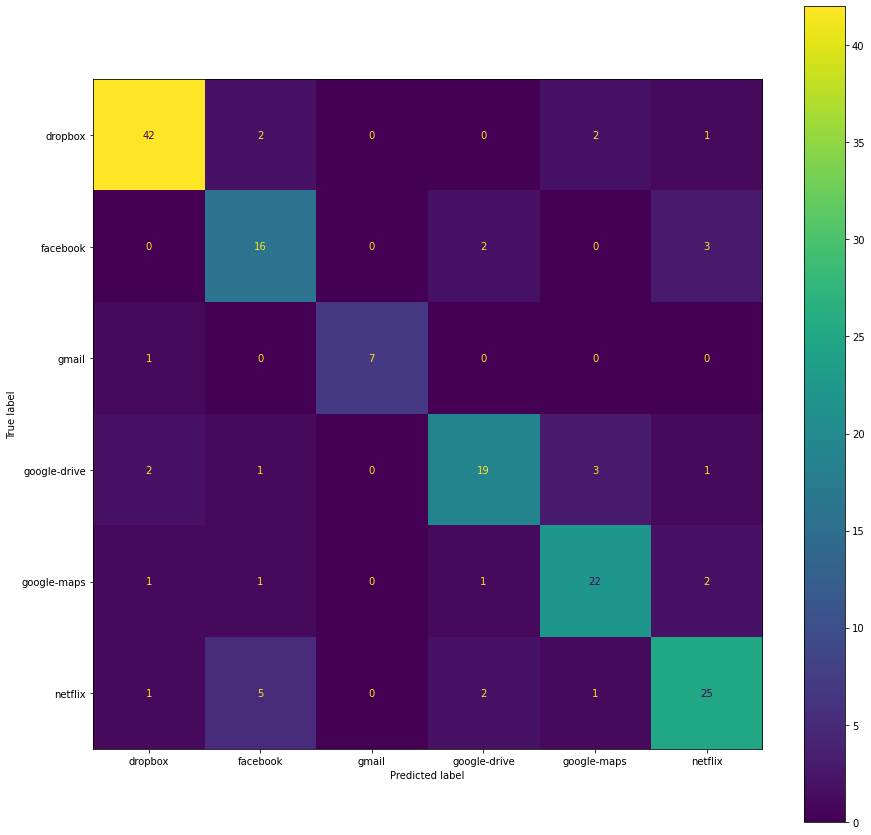

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15));
ConfusionMatrixDisplay.from_predictions(y_pred, Y[test], ax=ax, display_labels=le.inverse_transform(np.arange(len(apps))));
